# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [149]:
#import necessary packages 
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from sklearn.model_selection import train_test_split
import cv2


%matplotlib inline


In [150]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = "Data/train.p"
testing_file =  "Data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [151]:
### Setting training and test set here.

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [152]:
### Data exploration visualization goes next

import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import cv2

---
### Normalization process 

Label: 40


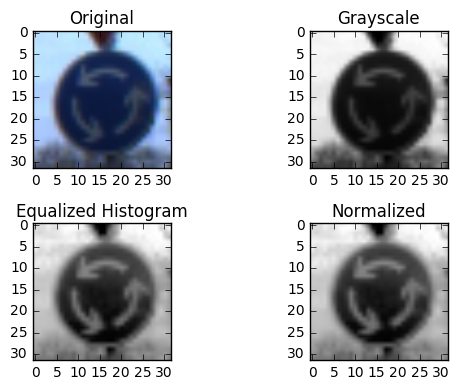

In [153]:
###Lets do shuffling and visualize image with our normalization process 
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

im = 0
# Copy the image
orig = np.copy(X_train[0,...])
print('Label: %d' % (y_train[im]))

# Convert to grayscale
grayscale = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# Equalize the histogram
eq_gray_hist = cv2.equalizeHist(grayscale)

# Normalize the values
norm_gray = eq_gray_hist/255. - 0.5

# Plot the results
fig = plt.figure()

#show the original plot
grid = plt.subplot(2,2,1)
grid.set_title('Original')
grid.imshow(orig)

#show the grayscale picture
grid = plt.subplot(2,2,2)
grid.set_title('Grayscale')
grid.imshow(grayscale, cmap='gray')

#show the equalized histogram picture
grid = plt.subplot(2,2,3)
grid.set_title('Equalized Histogram')
grid.imshow(eq_gray_hist, cmap='gray')

#show the normalized picture
grid = plt.subplot(2,2,4)
grid.set_title('Normalized')
grid.imshow(norm_gray, cmap='gray')

plt.tight_layout()
plt.show()

------- 
Highest count: 2250.0 (class 2)
Lowest count: 210.0 (class 0)
------- 


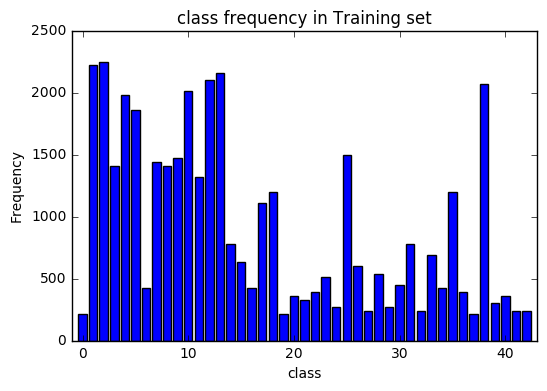

In [154]:
# Create a barchart of frequencies
# Display highest count and lowest count of classes

assert (n_classes == len( np.unique(y_train) )), '1 or more class(es) not represented in training set'
        
def class_freq_hig_low_count(y, verbose=False):
    num_classes = len(np.unique(y))
    n_imgs_per_class = np.zeros( num_classes )

    for this_class in range( num_classes ):
        if verbose: 
            print('class {} | count {}'.format(this_class, np.sum( y  == this_class )) )
        n_imgs_per_class[this_class] = np.sum(y == this_class )
    
    return n_imgs_per_class


class_freq = class_freq_hig_low_count(y_train)
print('------- ')
print('Highest count: {} (class {})'.format(np.max(class_freq), np.argmax(class_freq)))
print('Lowest count: {} (class {})'.format(np.min(class_freq), np.argmin(class_freq)))
print('------- ')
plt.bar(np.arange(n_classes), class_freq , align='center')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1, 43])
plt.title("class frequency in Training set")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Converting images to gray scale reduces the total size of the dataset by 66% by going from 3 color channels to just 1. This will improve the speed of the algorithm without sacrificing much information. The main features of a traffic sign are present in the shapes of the signs. OpenCV provides helper functions to make these transformations with just a few lines of code.

Using the normalization method outlined above, we create the function pre_process_gray to generalize the method to multiple images.

In [155]:
### Preprocess the data here.
### Doing here pre processing ,converting the image to greyscale 
def pre_process_gray(images):
    # Convert images to grayscale histogram equalize,
    tmp = []
    for i in range(images.shape[0]):
        gray = cv2.cvtColor(images[i,...], cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)
        norm_grey = gray/255. - 0.5
        tmp.append(norm_grey)
        
    tmp = np.array(tmp)
    return tmp[...,np.newaxis]


def center_normalization(X_train):
    x_train = X_train.astype(np.float32)
    x_train -= np.mean(x_train, axis=0)
    x_train /= np.std(x_train, axis=0)

    return x_train

def one_hot(array):
    if array.ndim > 1: return array
    return np.array([[1 if j == array[i] else 0 for j in range(n_classes)] \
                     for i in range(len(array))])

def de_one_hot(array):
    if array.ndim == 1: return array
    return np.array([i.argmax() for i in array])

In [156]:
print("Original Data Dimensions:\nData: %r | Labels: %r\n" % (X_train.shape, y_train.shape))

X_train = pre_process_gray(X_train)
#X_train = center_normalization(X_train)
print("Pre-Processed Data Dimensions:\nData: %r | Labels: %r\n" % (X_train.shape, y_train.shape))

Original Data Dimensions:
Data: (39209, 32, 32, 3) | Labels: (39209,)

Pre-Processed Data Dimensions:
Data: (39209, 32, 32, 1) | Labels: (39209,)



### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

1) The first step I took to pre-process the images was to convert them to grayscale.

2) I chose to convert them to grayscale by a process of elimination.

3) Converting images to gray scale reduces the total size of the dataset by 66% by going from 3 color channels to just 1. 

4) This will improve the speed of the algorithm without sacrificing much information. 

5) The main features of a traffic sign are present in the shapes of the signs. OpenCV provides helper functions to make these transformations with just a few lines of code.

6) The method I chose to use was equalizing the histogram of the image, as it was easy to implement with cv2.

7) I normalized the pixel range to between [-0.5, 0.5] to create a well-conditioned problem for the optimizer to converge to a solution.


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer**

**Data Augmentation**

Now that our images are transformed and normalized, we need to expand the dataset to give the model a better chance of converging to a solution.

I did look into differnet papers that had the same topic , the way they addressed creating additional data from given data set. Affine transform is one approach of them. 


Affine transformations are any linear transformation of a matrix which maintains the parrallelism of the lines in the image. When viewing an object from a fixed viewpoint, we can simulate the view of the same object from a different viewpoint by using affine transformations.
Examples of such transformations include rotation, translation, and shear.

Using the below function, we will create randomized transformations of our training images to simulate viewing the traffic signs from different angles, with the hope that this will make our model more robust in classification of new images.

This is one such paper that i came across, that explained me mathematically about affine transform http://merganser.math.gvsu.edu/david/reed03/notes/chap4.pdf 

opencv tutorial that i read for this is 
http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html

In [157]:
### Generate data additional data (OPTIONAL!)

def transformation_fun(image, angle, shear, translation):
    ang_rot = np.random.uniform(angle) - angle/2
    rows, cols, color_channels = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)

    trans_x = translation*np.random.uniform() - translation/2
    trans_y = translation*np.random.uniform() - translation/2
    translation_matrix = np.array([[1, 0, trans_x],[0, 1, trans_y]]).astype('float32')
    
    pts1 = np.array([[5,5],[20,5],[5,20]]).astype('float32')
    
    pt1 = 5 + shear*np.random.uniform()- shear/2
    pt2 = 20 + shear*np.random.uniform()- shear/2
    
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_matrix = cv2.getAffineTransform(pts1, pts2)
        
    image = cv2.warpAffine(image, rotation_matrix, (cols,rows))
    image = cv2.warpAffine(image, translation_matrix,(cols,rows))
    image = cv2.warpAffine(image, shear_matrix, (cols,rows))
    
    return image

***Test an Image ***

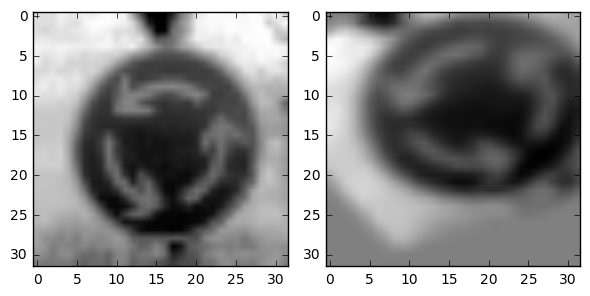

In [158]:
im = 0

out_transformed_image = transformation_fun(X_train[im,...], 20, 10, 5)
stacked = np.dstack((X_train[im,...], out_transformed_image))

grid = plt.subplot(1,2,1)
plt.imshow(stacked[...,0], cmap='gray')

grid = plt.subplot(1,2,2)
plt.imshow(out_transformed_image, cmap='gray')

plt.tight_layout()

Now we need to scaling factors to increase the images count, 
we already have the images frequency calculated above under class_freq_hig_low_count 

the logic follwed is as below :

for  <500 observations, increase count by 10x

for  <1000 observations, increase count by 5x

Else, for any other class increase count by 2x

In [159]:
segregated_data = []
class_obs = []

for class_ in range(n_classes):
    segregated_class = X_train[y_train == class_,...]
    segregated_data.append(segregated_class)
    class_obs.append(segregated_class.shape[0])

In [160]:
def expand_class(images, n_obs):
    transformed_images = []
    
    if n_obs < 500: factor = 10
    elif n_obs < 1000: factor = 5
    else: factor = 2
    
    for image in images:
        for _ in range(factor-1):
            transformed_images.append(transformation_fun(image, 20, 10, 5))
    
    transformed_images = np.array(transformed_images)
    transformed_images = transformed_images[...,np.newaxis]
    expanded_class = np.concatenate((images, transformed_images), axis=0)
    return (expanded_class, expanded_class.shape[0])

In [161]:
expanded_data = None
expanded_labels = None

for class_, images in enumerate(segregated_data):
    if expanded_data is None:
        expanded_data, obs = expand_class(images, class_obs[class_])
        expanded_labels = np.full(obs, class_, dtype='int64')
    else:
        tmp, obs = expand_class(images, class_obs[class_])
        expanded_data = np.concatenate((expanded_data, tmp), axis=0)
        expanded_labels = np.concatenate((expanded_labels, np.full(obs, class_, dtype='int64')), axis=0)

del segregated_data, class_obs
print("Expanded Data Dims:\nData: %r | Labels: %r\n" % (expanded_data.shape, expanded_labels.shape))

Expanded Data Dims:
Data: (139765, 32, 32, 1) | Labels: (139765,)



------- 
Highest count: 4500.0 (class 2)
Lowest count: 2100.0 (class 0)
------- 


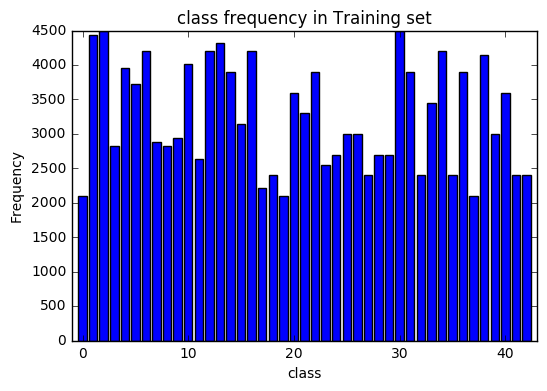

In [162]:

class_freq = class_freq_hig_low_count(expanded_labels)
print('------- ')
print('Highest count: {} (class {})'.format(np.max(class_freq), np.argmax(class_freq)))
print('Lowest count: {} (class {})'.format(np.min(class_freq), np.argmin(class_freq)))
print('------- ')
plt.bar(np.arange(n_classes), class_freq , align='center')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1, 43])
plt.title("class frequency in Training set")
plt.show()

We see that our transform works fine. we need to prepare helper functions for expanding the data 

Now that the data set expansion is done , we need to split this data into training and validation sets.next step is to divide the data into training set and validation set. For this i will have to create a function for data division , keeping 80% for training and 20 % for validation. 

In [163]:
def train_valid_set_split(data, labels, train_percent):
    n_obs = data.shape[0]
    assert n_obs == labels.shape[0], "Different number of images and labels"
    
    data, labels = shuffle(data, labels)
    
    cutoff = np.round(train_percent * n_obs).astype('int64')
    
    train = (data[:cutoff,...], labels[:cutoff])
    val = (data[cutoff:,...], labels[cutoff:])
    
    assert train[0].shape[0] + val[0].shape[0] == n_obs, "I fucked up"
    return (train, val)

In [164]:
train_percent = 0.8

expanded_labels = one_hot(expanded_labels)
train, val = train_valid_set_split(expanded_data, expanded_labels, train_percent)

X_test, y_test = pre_process_gray(X_test), one_hot(y_test)
test = (X_test, y_test)

print("Train Size: %d | Val Size: %d | Test Size: %d"
     % (train[0].shape[0], val[0].shape[0], test[0].shape[0]))


Train Size: 111812 | Val Size: 27953 | Test Size: 12630


In [165]:
def leaky_relu(x, alpha=0.1):
    import tensorflow as tf
    
    alpha = tf.constant(alpha)
    return tf.maximum(alpha*x, x)

In [166]:
from utils import ConvNet

signal_class = ConvNet(batch_size=64, color_channels=1, image_shape=(32,32), 
                         n_classes=43, learning_rate=1e-3)


signal_class.conv2d('L0', kernel_size=1, depth=3, ACTIVATION=leaky_relu)

signal_class.conv2d('L1_1', kernel_size=3, depth=32, input_padding=1, ACTIVATION=leaky_relu)
signal_class.conv2d('L1_2', kernel_size=3, depth=32, input_padding=1, ACTIVATION=leaky_relu)
signal_class.pool2d('MAX')

signal_class.conv2d('L2_1', kernel_size=3, depth=64, input_padding=2, ACTIVATION=leaky_relu)
signal_class.conv2d('L2_2', kernel_size=3, depth=64, input_padding=2, ACTIVATION=leaky_relu)
signal_class.pool2d('MAX')

signal_class.conv2d('L3_1', kernel_size=3, depth=128, input_padding=1, ACTIVATION=leaky_relu)
signal_class.conv2d('L3_2', kernel_size=3, depth=128, input_padding=1, ACTIVATION=leaky_relu)
signal_class.pool2d('MAX')

signal_class.fully_connected('FC1', 1024)
signal_class.fully_connected('FC2', 512)
signal_class.fully_connected('OUT', 43, ACTIVATION=None)

In [167]:
#signal_class.train(train, val, training_epochs=1000, l2_beta=0.001, threshold=0.982)

In [168]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [169]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [170]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [171]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [172]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.